# Construction de la BDD

In [1]:
from build_nba_bdd import export_all_seasons, export_all_teams_seasons, export_all_salaries, scrape_mvp_data, merge_data

In [ ]:
export_all_seasons()

In [ ]:
export_all_teams_seasons() # 5min environ

In [ ]:
export_all_salaries()

In [ ]:
scrape_mvp_data()

In [ ]:
merge_data() # Pour créer le data set sur lequel appliquer nos modèles (que pour Regular Season pour l'instant)

# Modèle de prédiction des salaires
Entraînement d'un modèle Random Forest pour prédire les salaires ajustés à l'inflation pour un joueur pour l'année n+1 à partir de toutes les données disponibles (performance joueur, équipe, salaire passé etc). Ce type de modèle pourrait être utilisé par les équipes de NBA pour décider de l'augmentation ou non des salaires de ses joueurs, ou de proposer le bon salaire à un joeur qu'ils souhaitent recruter.

Ici, l'utilisation des randoms forests est pertinent car l'évolution des salaires en NBA ne suivent pas une progression linéaire simple (comme on a pu le voir précedemment). De plus, la robustesse de ce type de modèle vis à vis des outliers est très intéressante : on a des superstars payées 40M+ l'année qui peuvent faire face à une réduction très importante de leur salaire (50% jusqu'à 99%) à cause de leur âge. Ce genre de modèle permet également de déterminer quelles sont les features les plus importantes pour la prédiction des salaires, permettant ainsi de faciliter l'interprétation des résultats du modèle.


## Nettoyage de la BDD

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
# Chargement de la base de données contenant les infos + performances des joueurs de la saison 99-00 à 24-25
df = pd.read_csv('./data/merged_data.csv')

print(f"Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")
print(f"\nAperçu des colonnes:")
print(df.columns.tolist())

Dataset chargé: 10284 lignes, 78 colonnes

Aperçu des colonnes:
['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK', 'TEAM_COUNT', 'Rank', 'Position', 'Team', 'Salary', 'Season', 'TEAM_W_PCT', 'Year', 'adjusted_salary', 'next_adjusted_salary', 'Changed_team', 'YOE']


In [4]:
# On regarde le nombre de personnes par tranche de salaire ajusté (ajusté à l'inflation)

# Créer des tranches de salaire personnalisées
salary_brackets = [0, 600000, 1000000, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 45000000, 50000000, float('inf')]
salary_bracket_labels = ['<600K', '600K-1M', '1M-5M', '5M-10M', '10M-15M', '15M-20M', '20M-25M', '25M-30M', '30M-35M', '35M-40M', '40M-45M', '45M-50M', '>50M']

# Catégoriser les salaires ajustés
df['salary_bracket'] = pd.cut(df['adjusted_salary'], bins=salary_brackets, labels=salary_bracket_labels, include_lowest=True)

# Compter le nombre de personnes par tranche
salary_distribution = df['salary_bracket'].value_counts().sort_index()

print("\nNombre de personnes par tranche de salaire:")
print("="*50)
for bracket, count in salary_distribution.items():
    print(f"{bracket:>10}: {count:>5} personnes ({count/len(df)*100:>5.1f}%)")
print("="*50)
print(f"{'Total':>10}: {len(df):>5} personnes")

# Supprimer la colonne salary_bracket du dataframe original
df = df.drop(columns=['salary_bracket'])



Nombre de personnes par tranche de salaire:
     <600K:   474 personnes (  4.6%)
   600K-1M:   503 personnes (  4.9%)
     1M-5M:  4638 personnes ( 45.1%)
    5M-10M:  2003 personnes ( 19.5%)
   10M-15M:   982 personnes (  9.5%)
   15M-20M:   615 personnes (  6.0%)
   20M-25M:   451 personnes (  4.4%)
   25M-30M:   228 personnes (  2.2%)
   30M-35M:   158 personnes (  1.5%)
   35M-40M:   107 personnes (  1.0%)
   40M-45M:    60 personnes (  0.6%)
   45M-50M:    36 personnes (  0.4%)
      >50M:    29 personnes (  0.3%)
     Total: 10284 personnes


On remarque qu'environ 5% du dataset sont des joueurs avec un salaire ajusté inférieur à 600k. Or le salaire minimum en 99 était de 300k$ environ, donc environ 600k$ en salaire ajusté. On supprime donc les données associées.

In [5]:
# Supprimer les lignes où next_adjusted_salary < 600000
print(f"Dataset avant filtrage: {len(df)} lignes")
df = df[df['Salary'] >= 300000]
df = df[df['next_adjusted_salary'] >= 600000]
print(f"Dataset après filtrage sur les salaires): {len(df)} lignes")

Dataset avant filtrage: 10284 lignes
Dataset après filtrage sur les salaires): 7902 lignes


On catégorise la position des joueurs pour pouvoir l'exploiter

In [6]:
# Catégoriser la colonne Position avant de la supprimer
if 'Position' in df.columns:
    print(f"\n Positions uniques des joueurs trouvées:")
    print(df['Position'].value_counts())
    
    # Créer un mapping des positions vers des catégories numériques
    position_mapping = {
        'PG': 1,   # Point Guard
        'SG': 2,   # Shooting Guard
        'SF': 3,   # Small Forward
        'PF': 4,   # Power Forward
        'C': 5,    # Center
        'G': 6,    # Guard (générique)
        'F': 7,    # Forward (générique)
        'GF': 8,  # Guard-Forward
        '': 9     # Position inconnue
    }
    
    # Appliquer le mapping aux positions des joueurs
    df['position_category'] = df['Position'].map(position_mapping).fillna(0).astype(int)
    print(f"\n Colonne 'position_category' créée:")


 Positions uniques des joueurs trouvées:
Position
G     1513
C     1423
F     1396
PF    1007
SF     865
PG     853
SG     838
Name: count, dtype: int64

 Colonne 'position_category' créée:


On supprime les colonnes inutiles pour le modèle

In [7]:
# Supprimer les colonnes inutiles pour la prédiction
columns_to_drop = ['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ABBREVIATION', 'Team', 'Salary', 'Season', 'Position', 'Rank']

# Vérifier quelles colonnes existent réellement
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
print(f"\n Colonnes à supprimer: {existing_columns_to_drop}")

df_clean = df.drop(columns=existing_columns_to_drop)

print(f"\n Dataset après nettoyage: {len(df_clean)} lignes, {len(df_clean.columns)} colonnes")
print(f"Colonnes restantes: {df_clean.columns.tolist()}")


 Colonnes à supprimer: ['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ABBREVIATION', 'Team', 'Salary', 'Season', 'Position', 'Rank']

 Dataset après nettoyage: 7902 lignes, 70 colonnes
Colonnes restantes: ['TEAM_ID', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK', 'TEAM_COUNT', 'TEAM_W_PCT', 'Year', 'adjusted_salary', 'next_adjusted_salary', 'Changed_team', 'YOE', 'position_categor

Même chose avec les saisons

In [8]:
# Créer une colonne catégorielle pour les saisons à partir de 'Year'
# Extraire l'année de début (ex: '1999-00' -> 1999)
df_clean['season_start_year'] = df_clean['Year'].str.split('-').str[0].astype(int)

# Créer une colonne catégorielle (1 pour 1999-00, 2 pour 2000-01, etc.)
min_year = df_clean['season_start_year'].min()
df_clean['season_category'] = df_clean['season_start_year'] - min_year + 1

print(f"\n Catégories de saisons créées:")
print(f"   Année minimale: {min_year} (catégorie 1)")
print(f"   Année maximale: {df_clean['season_start_year'].max()} (catégorie {df_clean['season_category'].max()})")

# Supprimer les colonnes temporaires et Year
df_clean = df_clean.drop(columns=['Year', 'season_start_year'])


 Catégories de saisons créées:
   Année minimale: 1999 (catégorie 1)
   Année maximale: 2023 (catégorie 25)


On gère les valeurs manquantes (aucune normalement grâce au code de construction de la BDD). On supprime les lignes sans next_ajusted_salary (variable cible donc nécessaire).

In [9]:
# Gérer les valeurs manquantes
print(f"\n Valeurs manquantes par colonne:")
missing_values = df_clean.isnull().sum()
print(missing_values[missing_values > 0])

# Supprimer les lignes où next_adjusted_salary est vide
df_clean = df_clean.dropna(subset=['next_adjusted_salary'])

print(f"\n Dataset final prêt pour l'entraînement: {len(df_clean)} lignes, {len(df_clean.columns)} colonnes")


 Valeurs manquantes par colonne:
Series([], dtype: int64)

 Dataset final prêt pour l'entraînement: 7902 lignes, 70 colonnes


## Creation des subsets d'entrainement, test, cible

In [10]:
# Séparer les features (X) et la cible (y)
X = df_clean.drop(columns=['next_adjusted_salary'])
y = df_clean['next_adjusted_salary']

print(f" Variable cible: next_adjusted_salary")
print(f" Features: {len(X.columns)} colonnes")
print(f"   Nombre d'exemples: {len(X)}")
print(f"\n Statistiques de la variable cible:")
print(f"   Moyenne: ${y.mean():,.0f}")
print(f"   Médiane: ${y.median():,.0f}")
print(f"   Min: ${y.min():,.0f}")
print(f"   Max: ${y.max():,.0f}")

 Variable cible: next_adjusted_salary
 Features: 69 colonnes
   Nombre d'exemples: 7902

 Statistiques de la variable cible:
   Moyenne: $9,381,211
   Médiane: $5,805,256
   Min: $605,238
   Max: $57,434,052


In [11]:
# Diviser les données en ensembles d'entraînement et de test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f" Division des données:")
print(f"   Entraînement: {len(X_train)} exemples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test: {len(X_test)} exemples ({len(X_test)/len(X)*100:.1f}%)")

 Division des données:
   Entraînement: 5531 exemples (70.0%)
   Test: 2371 exemples (30.0%)


## Entrainement du modèle de random forest

In [12]:
# Créer et entraîner le modèle Random Forest
print("Entraînement du modèle Random Forest...")

rf_model = RandomForestRegressor(
    n_estimators=100,      # Nombre d'arbres
    max_depth=8,          # Profondeur maximale des arbres
    min_samples_split=5,   # Nombre minimum d'échantillons pour diviser un nœud
    min_samples_leaf=3,    # Nombre minimum d'échantillons par feuille
    random_state=42,       # Pour la reproductibilité
    n_jobs=-1,             # Utiliser tous les cœurs CPU
    verbose=0              # Afficher la progression
)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

print("\n Modèle entraîné avec succès!")

Entraînement du modèle Random Forest...

 Modèle entraîné avec succès!


## Performances du modèle

In [13]:
# Faire des prédictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculer les métriques de performance
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("="*60)
print(" RÉSULTATS DU MODÈLE RANDOM FOREST")
print("="*60)
print("\n Ensemble d'entraînement:")
print(f"   MAE (Mean Absolute Error):  ${train_mae:,.0f}")
print(f"   RMSE (Root Mean Squared Error): ${train_rmse:,.0f}")
print(f"   R² Score: {train_r2:.4f}")

print("\n Ensemble de test:")
print(f"   MAE (Mean Absolute Error):  ${test_mae:,.0f}")
print(f"   RMSE (Root Mean Squared Error): ${test_rmse:,.0f}")
print(f"   R² Score: {test_r2:.4f}")

print("\n Interprétation:")
print(f"   Le modèle se trompe en moyenne de ${test_mae:,.0f}")
print(f"   Il explique {test_r2*100:.1f}% de la variance des salaires")
print("="*60)

 RÉSULTATS DU MODÈLE RANDOM FOREST

 Ensemble d'entraînement:
   MAE (Mean Absolute Error):  $1,638,635
   RMSE (Root Mean Squared Error): $2,765,059
   R² Score: 0.9170

 Ensemble de test:
   MAE (Mean Absolute Error):  $2,269,585
   RMSE (Root Mean Squared Error): $4,068,067
   R² Score: 0.8079

 Interprétation:
   Le modèle se trompe en moyenne de $2,269,585
   Il explique 80.8% de la variance des salaires


On constate que le modèle a de plutôt bonnes performances, avec un R^2 à 80% sur le jeu de test. Il est important de noté qu'il y a un écart de 10% avec le R^2 des données d'entraînement. Il semble donc avoir un léger overfitting.

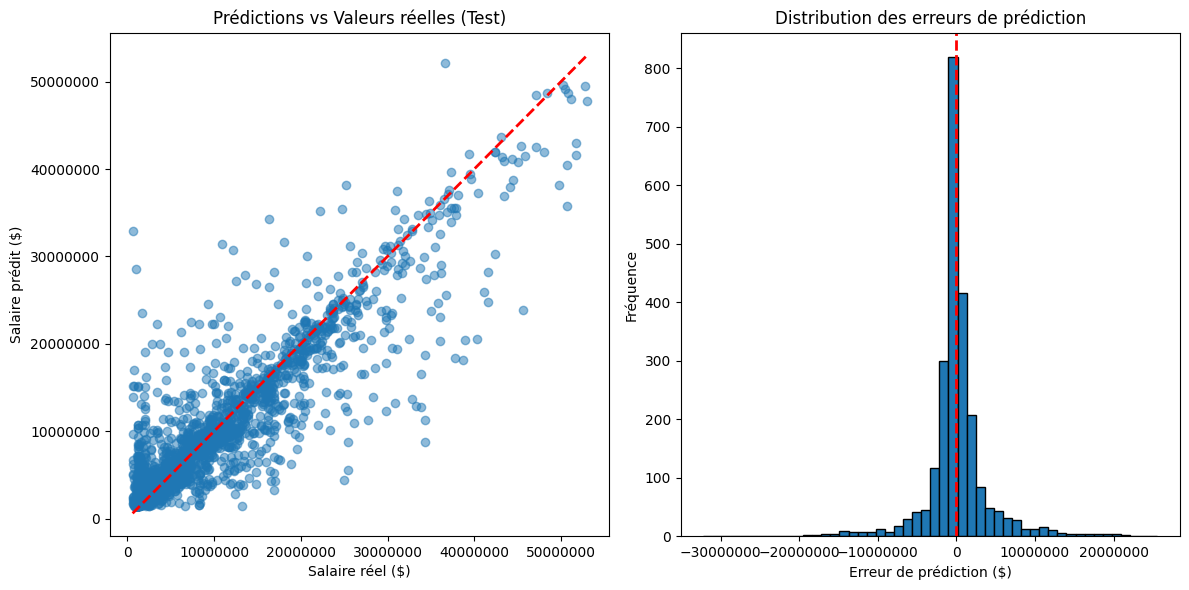


 Statistiques des erreurs:
   Erreur moyenne: $85,661
   Écart-type des erreurs: $4,068,023


In [14]:
# Visualiser les prédictions vs valeurs réelles
plt.figure(figsize=(12, 6))

# Graphique 1: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Salaire réel ($)')
plt.ylabel('Salaire prédit ($)')
plt.title('Prédictions vs Valeurs réelles (Test)')
plt.ticklabel_format(style='plain', axis='both')

# Graphique 2: Distribution des erreurs
plt.subplot(1, 2, 2)
errors = y_test - y_test_pred
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Erreur de prédiction ($)')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

print(f"\n Statistiques des erreurs:")
print(f"   Erreur moyenne: ${errors.mean():,.0f}")
print(f"   Écart-type des erreurs: ${errors.std():,.0f}")

Etudions maintenant la répartition des erreurs 

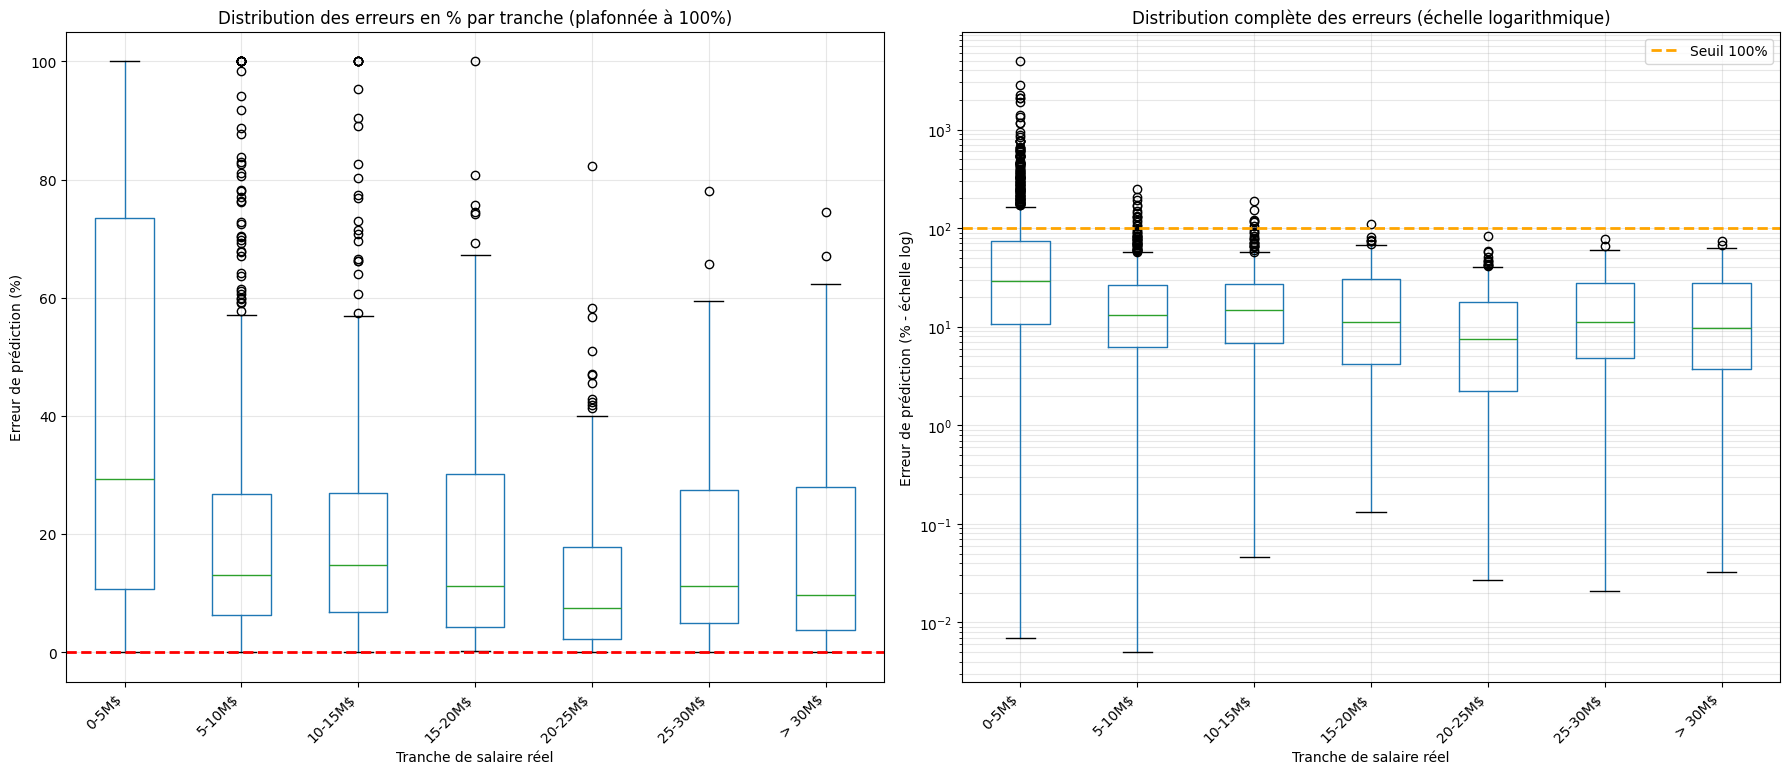

In [15]:
# Créer des tranches de salaire pour analyser les erreurs
salary_brackets = [0, 5_000_000, 10_000_000, 15_000_000, 20_000_000, 25_000_000, 30_000_000, float('inf')]
salary_bracket_labels = ['0-5M$', '5-10M$', '10-15M$', '15-20M$', '20-25M$', '25-30M$', '> 30M$']

# Binning des salaires de test
y_test_binned = pd.cut(y_test, bins=salary_brackets, labels=salary_bracket_labels)

# Calculer les erreurs en pourcentage (plafonnées à 100%)
error_pct = (errors.abs() / y_test) * 100
error_pct = error_pct.clip(upper=100)  # Plafonner à 100%

# Créer le DataFrame d'analyse
error_analysis_pct = pd.DataFrame({
    'error_pct': error_pct,
    'salary_range': y_test_binned
})

# Créer deux subplots pour mieux visualiser
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Graphique 1: Vue normale (plafonnée à 100%)
error_analysis_pct.boxplot(column='error_pct', by='salary_range', ax=ax1)
ax1.set_xlabel('Tranche de salaire réel')
ax1.set_ylabel('Erreur de prédiction (%)')
ax1.set_title('Distribution des erreurs en % par tranche (plafonnée à 100%)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_ylim(-5, 105)
ax1.grid(True, alpha=0.3)

# Graphique 2: Vue complète (erreurs non plafonnées)
error_pct_full = (errors.abs() / y_test) * 100  # Sans plafonnement
error_analysis_full = pd.DataFrame({
    'error_pct': error_pct_full,
    'salary_range': y_test_binned
})
error_analysis_full.boxplot(column='error_pct', by='salary_range', ax=ax2)
ax2.set_xlabel('Tranche de salaire réel')
ax2.set_ylabel('Erreur de prédiction (% - échelle log)')
ax2.set_title('Distribution complète des erreurs (échelle logarithmique)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yscale('log')  # Échelle logarithmique pour voir les extrêmes
ax2.axhline(y=100, color='orange', linestyle='--', linewidth=2, label='Seuil 100%')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend()

plt.suptitle('')
plt.tight_layout()
plt.show()

En première instance, on remarque que, globalement, l'erreur (en proportion) est plus élevée sur les tranches de salaire plus basse (on a des erreurs à plus de 1000%). Ceci peut sembler contre intuitif car on a plus données avec des salaire bas / moyens que élevés. Mais ce phénomène a une explication ! Comme expliqué plus haut, il arrive qu'après une longue carrière le salaire des superstars chutent brutalement d'une saison à l'autre pour pouvoir continuer à jouer en NBA (comme l'illustre le tableau ci-dessous). Le nombre de données dans ce cas est significatif (544 avec une baisse d'au moins 50%) et influence très clairement l'erreur sur les bas salaires.
On pourrait enlever ces outliers pour améliorer les performances du modèle, mais il serait préférable que celui-ci puisse "comprendre" ce phénomène pour pouvoir faire des prévisions extrêmement réaliste sur le marché des échanges en NBA. 

In [16]:
# Calculer la baisse de salaire en pourcentage
df_salary_changes = df_clean.copy()
df_salary_changes['salary_change'] = df_salary_changes['next_adjusted_salary'] - df_salary_changes['adjusted_salary']
df_salary_changes['salary_change_pct'] = (df_salary_changes['salary_change'] / df_salary_changes['adjusted_salary']) * 100

# Filtrer les joueurs avec une baisse d'au moins 50%
big_salary_drops = df_salary_changes[df_salary_changes['salary_change_pct'] <= -50].copy()

# Trier par pourcentage de baisse (du plus négatif au moins négatif)
big_salary_drops = big_salary_drops.sort_values('salary_change_pct')

# Récupérer les informations des joueurs depuis le DataFrame original
big_salary_drops_info = df.loc[big_salary_drops.index, ['PLAYER_NAME', 'Year', 'adjusted_salary']].copy()
big_salary_drops_info['next_adjusted_salary'] = big_salary_drops['next_adjusted_salary']
big_salary_drops_info['salary_change'] = big_salary_drops['salary_change']
big_salary_drops_info['salary_change_pct'] = big_salary_drops['salary_change_pct']

print(f"Nombre de joueurs ayant subi une baisse de salaire d'au moins 50%: {len(big_salary_drops_info)}")
print("\n" + "="*100)
print(f"{'Joueur':<25} {'Saison':<10} {'Salaire actuel':>18} {'Salaire suivant':>18} {'Changement':>18} {'% Baisse':>10}")
print("="*100)

for idx, row in big_salary_drops_info.head(20).iterrows():
    print(f"{row['PLAYER_NAME']:<25} {row['Year']:<10} ${row['adjusted_salary']:>16,} ${row['next_adjusted_salary']:>16,.0f} ${row['salary_change']:>16,.0f} {row['salary_change_pct']:>9.1f}%")

print("="*100)
print(f"\nAffichage des 20 plus grosses baisses sur {len(big_salary_drops_info)} au total")

Nombre de joueurs ayant subi une baisse de salaire d'au moins 50%: 544

Joueur                    Saison         Salaire actuel    Salaire suivant         Changement   % Baisse
Ben Simmons               2023-24    $      40,167,012 $         778,501 $     -39,388,511     -98.1%
Chris Webber              2005-06    $      31,747,500 $         655,774 $     -31,091,726     -97.9%
Blake Griffin             2019-20    $      43,751,454 $         971,229 $     -42,780,225     -97.8%
Enes Freedom              2017-18    $      24,581,718 $         628,371 $     -23,953,347     -97.4%
Jeff Teague               2019-20    $      24,130,000 $         638,236 $     -23,491,764     -97.4%
Wesley Matthews           2017-18    $      23,607,112 $         661,442 $     -22,945,670     -97.2%
Danilo Gallinari          2021-22    $      24,570,000 $         701,326 $     -23,868,674     -97.1%
Andre Drummond            2019-20    $      34,408,134 $         993,170 $     -33,414,964     -97.1%
Reggie 

Enfin, regardons les features les plus importantes pour la prédiction.

In [17]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n TOP 5 des variables les plus importantes:")
print(feature_importance.head(5).to_string(index=False))


 TOP 5 des variables les plus importantes:
         feature  importance
 adjusted_salary    0.808652
 NBA_FANTASY_PTS    0.029062
WNBA_FANTASY_PTS    0.021878
             YOE    0.017212
             AGE    0.008083


Comme on pouvait s'en douter, le salaire précédent contribue en grande partie à la prédiction du salaire de l'année suivante. Bien que cohérent et utile pour la gestion des salaires des équipes, ceci n'est pas très stimulant d'un point de vue prédictif. Ainsi on entrainera le modèle sans cette donnée dans la suite de l'étude.

Mais il est intéressant de noter que les 2 variables les plus importantes après celle du salaire passé sont les xx_FANTASY_POINTS, qui sont une mesure établie par la NBA à partir des performances d'un joueur sur une année. On pourra donc essayer d'entraîner le modèle sans les FANTASY_POINTS pour voir si le random_forest arrive à atteindre le mêmes performances grâce à toutes les données utilisées pour construire les FANTASY_POINTS. 

Enfin, il est inétressant de constater que l'âge et le nombre d'années passées en NBA sont également relativement importantes pour le calcul du salaire. Ceci est cohérent car un rookie gagnera moins qu'un joueur expérimenté selon les grilles de salaire de la NBA.

# Étude comparative : Impact des features sur les performances du modèle

Nous allons maintenant entraîner 3 modèles différents pour évaluer l'impact de certaines features clés :
1. **Modèle sans adjusted_salary** : Pour voir si on peut prédire sans le salaire précédent
2. **Modèle sans FANTASY_POINTS** : Pour voir si les statistiques brutes suffisent
3. **Modèle sans adjusted_salary ET sans FANTASY_POINTS** : Le plus difficile, uniquement avec les stats brutes

## Modèle 1 : Sans adjusted_salary (salaire précédent)

In [18]:
# Modèle 1 : Sans adjusted_salary
print("="*80)
print("MODÈLE 1 : SANS ADJUSTED_SALARY (salaire précédent)")
print("="*80)

# Créer X sans adjusted_salary
X_no_salary = X.drop(columns=['adjusted_salary'])
X_train_no_salary, X_test_no_salary, y_train_1, y_test_1 = train_test_split(
    X_no_salary, y, test_size=0.3, random_state=42
)

# Entraîner le modèle
rf_model_1 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model_1.fit(X_train_no_salary, y_train_1)

# Prédictions
y_train_pred_1 = rf_model_1.predict(X_train_no_salary)
y_test_pred_1 = rf_model_1.predict(X_test_no_salary)

# Métriques
train_mae_1 = mean_absolute_error(y_train_1, y_train_pred_1)
test_mae_1 = mean_absolute_error(y_test_1, y_test_pred_1)
train_r2_1 = r2_score(y_train_1, y_train_pred_1)
test_r2_1 = r2_score(y_test_1, y_test_pred_1)

print(f"\n Modèle entraîné avec {len(X_no_salary.columns)} features")
print(f"\n Performances sur l'ensemble de TEST:")
print(f"   MAE:  ${test_mae_1:,.0f}")
print(f"   R² Score: {test_r2_1:.4f} ({test_r2_1*100:.1f}%)")
print(f"\n Performances sur l'ensemble d'ENTRAÎNEMENT:")
print(f"   MAE:  ${train_mae_1:,.0f}")
print(f"   R² Score: {train_r2_1:.4f} ({train_r2_1*100:.1f}%)")

# Top 5 features importantes
feature_importance_1 = pd.DataFrame({
    'feature': X_no_salary.columns,
    'importance': rf_model_1.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n TOP 5 des variables les plus importantes:")
for idx, row in feature_importance_1.head(5).iterrows():
    print(f"   {row['feature']:<30} {row['importance']:.4f}")

print("="*80)

MODÈLE 1 : SANS ADJUSTED_SALARY (salaire précédent)

 Modèle entraîné avec 68 features

 Performances sur l'ensemble de TEST:
   MAE:  $3,383,522
   R² Score: 0.7103 (71.0%)

 Performances sur l'ensemble d'ENTRAÎNEMENT:
   MAE:  $2,638,085
   R² Score: 0.8503 (85.0%)

 TOP 5 des variables les plus importantes:
   WNBA_FANTASY_PTS               0.4411
   NBA_FANTASY_PTS                0.1575
   YOE                            0.1426
   season_category                0.0506
   AGE                            0.0306


## Modèle 2 : Sans FANTASY_POINTS

In [19]:
# Modèle 2 : Sans FANTASY_POINTS
print("="*80)
print("MODÈLE 2 : SANS FANTASY_POINTS")
print("="*80)

# Identifier les colonnes FANTASY_POINTS
fantasy_cols = [col for col in X.columns if 'FANTASY' in col.upper()]
print(f"\n Colonnes FANTASY_POINTS identifiées: {fantasy_cols}")

# Créer X sans FANTASY_POINTS
X_no_fantasy = X.drop(columns=fantasy_cols)
X_train_no_fantasy, X_test_no_fantasy, y_train_2, y_test_2 = train_test_split(
    X_no_fantasy, y, test_size=0.3, random_state=42
)

# Entraîner le modèle
rf_model_2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model_2.fit(X_train_no_fantasy, y_train_2)

# Prédictions
y_train_pred_2 = rf_model_2.predict(X_train_no_fantasy)
y_test_pred_2 = rf_model_2.predict(X_test_no_fantasy)

# Métriques
train_mae_2 = mean_absolute_error(y_train_2, y_train_pred_2)
test_mae_2 = mean_absolute_error(y_test_2, y_test_pred_2)
train_r2_2 = r2_score(y_train_2, y_train_pred_2)
test_r2_2 = r2_score(y_test_2, y_test_pred_2)

print(f"\n Modèle entraîné avec {len(X_no_fantasy.columns)} features")
print(f"\n Performances sur l'ensemble de TEST:")
print(f"   MAE:  ${test_mae_2:,.0f}")
print(f"   R² Score: {test_r2_2:.4f} ({test_r2_2*100:.1f}%)")
print(f"\n Performances sur l'ensemble d'ENTRAÎNEMENT:")
print(f"   MAE:  ${train_mae_2:,.0f}")
print(f"   R² Score: {train_r2_2:.4f} ({train_r2_2*100:.1f}%)")

# Top 5 features importantes
feature_importance_2 = pd.DataFrame({
    'feature': X_no_fantasy.columns,
    'importance': rf_model_2.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n TOP 5 des variables les plus importantes:")
for idx, row in feature_importance_2.head(5).iterrows():
    print(f"   {row['feature']:<30} {row['importance']:.4f}")

print("="*80)

MODÈLE 2 : SANS FANTASY_POINTS

 Colonnes FANTASY_POINTS identifiées: ['NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK']

 Modèle entraîné avec 65 features

 Performances sur l'ensemble de TEST:
   MAE:  $2,292,376
   R² Score: 0.8021 (80.2%)

 Performances sur l'ensemble d'ENTRAÎNEMENT:
   MAE:  $1,647,657
   R² Score: 0.9157 (91.6%)

 TOP 5 des variables les plus importantes:
   adjusted_salary                0.8140
   PTS                            0.0183
   YOE                            0.0164
   FGM                            0.0147
   MIN                            0.0103


## Modèle 3 : Sans adjusted_salary ET sans FANTASY_POINTS (Minimal)

In [20]:
# Modèle 3 : Sans adjusted_salary ET sans FANTASY_POINTS
print("="*80)
print("MODÈLE 3 : SANS ADJUSTED_SALARY ET SANS FANTASY_POINTS")
print("="*80)

# Créer X sans adjusted_salary ET sans FANTASY_POINTS
X_minimal = X.drop(columns=['adjusted_salary'] + fantasy_cols)
X_train_minimal, X_test_minimal, y_train_3, y_test_3 = train_test_split(
    X_minimal, y, test_size=0.3, random_state=42
)

# Entraîner le modèle
rf_model_3 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model_3.fit(X_train_minimal, y_train_3)

# Prédictions
y_train_pred_3 = rf_model_3.predict(X_train_minimal)
y_test_pred_3 = rf_model_3.predict(X_test_minimal)

# Métriques
train_mae_3 = mean_absolute_error(y_train_3, y_train_pred_3)
test_mae_3 = mean_absolute_error(y_test_3, y_test_pred_3)
train_r2_3 = r2_score(y_train_3, y_train_pred_3)
test_r2_3 = r2_score(y_test_3, y_test_pred_3)

print(f"\n Modèle entraîné avec {len(X_minimal.columns)} features")
print(f"\n Performances sur l'ensemble de TEST:")
print(f"   MAE:  ${test_mae_3:,.0f}")
print(f"   R² Score: {test_r2_3:.4f} ({test_r2_3*100:.1f}%)")
print(f"\n Performances sur l'ensemble d'ENTRAÎNEMENT:")
print(f"   MAE:  ${train_mae_3:,.0f}")
print(f"   R² Score: {train_r2_3:.4f} ({train_r2_3*100:.1f}%)")

# Top 5 features importantes
feature_importance_3 = pd.DataFrame({
    'feature': X_minimal.columns,
    'importance': rf_model_3.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n TOP 5 des variables les plus importantes:")
for idx, row in feature_importance_3.head(5).iterrows():
    print(f"   {row['feature']:<30} {row['importance']:.4f}")

print("="*80)

MODÈLE 3 : SANS ADJUSTED_SALARY ET SANS FANTASY_POINTS

 Modèle entraîné avec 64 features

 Performances sur l'ensemble de TEST:
   MAE:  $3,368,299
   R² Score: 0.7128 (71.3%)

 Performances sur l'ensemble d'ENTRAÎNEMENT:
   MAE:  $2,636,984
   R² Score: 0.8491 (84.9%)

 TOP 5 des variables les plus importantes:
   PTS                            0.3820
   YOE                            0.1480
   FGM                            0.1150
   MIN                            0.0677
   season_category                0.0513


## Tableau comparatif des performances

In [21]:
import pandas as pd

# Tableau comparatif des 4 modèles
comparison_df = pd.DataFrame({
    'Modèle': [
        'Modèle de base (toutes features)',
        'Sans adjusted_salary',
        'Sans FANTASY_POINTS',
        'Sans adjusted_salary ET FANTASY_POINTS (Minimal)'
    ],
    'Nombre de features': [
        len(X.columns),
        len(X_no_salary.columns),
        len(X_no_fantasy.columns),
        len(X_minimal.columns)
    ],
    'R² Test': [
        f"{test_r2:.4f} ({test_r2*100:.1f}%)",
        f"{test_r2_1:.4f} ({test_r2_1*100:.1f}%)",
        f"{test_r2_2:.4f} ({test_r2_2*100:.1f}%)",
        f"{test_r2_3:.4f} ({test_r2_3*100:.1f}%)"
    ],
    'MAE Test': [
        f"${test_mae:,.0f}",
        f"${test_mae_1:,.0f}",
        f"${test_mae_2:,.0f}",
        f"${test_mae_3:,.0f}"
    ],
    'R² Train': [
        f"{train_r2:.4f} ({train_r2*100:.1f}%)",
        f"{train_r2_1:.4f} ({train_r2_1*100:.1f}%)",
        f"{train_r2_2:.4f} ({train_r2_2*100:.1f}%)",
        f"{train_r2_3:.4f} ({train_r2_3*100:.1f}%)"
    ],
    'Écart Train-Test (R²)': [
        f"{(train_r2 - test_r2)*100:.1f}%",
        f"{(train_r2_1 - test_r2_1)*100:.1f}%",
        f"{(train_r2_2 - test_r2_2)*100:.1f}%",
        f"{(train_r2_3 - test_r2_3)*100:.1f}%"
    ]
})

print("\n" + "="*120)
print("COMPARAISON DES PERFORMANCES DES 4 MODÈLES")
print("="*120)
print(comparison_df.to_string(index=False))
print("="*120)


COMPARAISON DES PERFORMANCES DES 4 MODÈLES
                                          Modèle  Nombre de features        R² Test   MAE Test       R² Train Écart Train-Test (R²)
                Modèle de base (toutes features)                  69 0.8079 (80.8%) $2,269,585 0.9170 (91.7%)                 10.9%
                            Sans adjusted_salary                  68 0.7103 (71.0%) $3,383,522 0.8503 (85.0%)                 14.0%
                             Sans FANTASY_POINTS                  65 0.8021 (80.2%) $2,292,376 0.9157 (91.6%)                 11.4%
Sans adjusted_salary ET FANTASY_POINTS (Minimal)                  64 0.7128 (71.3%) $3,368,299 0.8491 (84.9%)                 13.6%


En comparant les performances des différents modèles, on constate un recul de 10% du R^2 sur les données test en enlevant le salaire de l'année passée des données d'entraînement. Même si cette baisse est significative, les performances du modèle restent néanmoins très bonnes : sans avoir aucune information sur les salaires, il est capable d'expliquer 70% de la variance des salaires. 
De plus, on observe que les performances du modèle sont quasiment identiques avec ou sans les données de type FANTASY. Ceci est cohérent car le calcul de ces points se fait à partir de données déjà présentes dans la BDD.

Maintenant, intéressons nous à l'impact de la suppression des données associées à une baisse drastique du salaire liée à l'âge, une blessure ... que le modèle a du mal à décrire.

## Impact des baisses de salaire extrêmes (>50%)

Pour mieux comprendre l'impact des baisses de salaire extrêmes sur les performances du modèle, entraînons deux modèles supplémentaires en **excluant les joueurs dont le salaire baisse de plus de 50%**. On comparera les performances et erreurs sur le modèle construit sur l'ensemble de la base de donnée, ainsi que celui construit à partir de la BDD minimale (sans salaire et fantasy).

D'abord, netoyons la base de donnée (retirer les baisses de salaire extrêmes) :

In [46]:
# Filtrer les données pour exclure les baisses de salaire > 50%
print("="*80)
print("FILTRAGE DES DONNÉES : EXCLUSION DES BAISSES DE SALAIRE > 50%")
print("="*80)

# Calculer le changement de salaire en pourcentage
salary_change_pct = ((df_clean['next_adjusted_salary'] - df_clean['adjusted_salary']) / df_clean['adjusted_salary']) * 100

# Créer un masque pour les données à conserver (pas de baisse > 50%)
mask_no_extreme_drops = salary_change_pct > -50

print(f"\nDataset original: {len(df_clean)} lignes")
print(f"Joueurs avec baisse > 50%: {(~mask_no_extreme_drops).sum()} ({(~mask_no_extreme_drops).sum()/len(df_clean)*100:.1f}%)")
print(f"Dataset filtré: {mask_no_extreme_drops.sum()} lignes ({mask_no_extreme_drops.sum()/len(df_clean)*100:.1f}%)")

# Créer les datasets filtrés
df_filtered = df_clean[mask_no_extreme_drops].copy()

# Créer X et y filtrés
X_filtered = df_filtered.drop(columns=['next_adjusted_salary'])
y_filtered = df_filtered['next_adjusted_salary']

print(f"\n Datasets filtrés créés")
print("="*80)

FILTRAGE DES DONNÉES : EXCLUSION DES BAISSES DE SALAIRE > 50%

Dataset original: 7902 lignes
Joueurs avec baisse > 50%: 544 (6.9%)
Dataset filtré: 7358 lignes (93.1%)

 Datasets filtrés créés


### Modèle 4 : Modèle de base sur données filtrées

In [47]:
# Modèle 4 : Modèle de base sur données filtrées (sans baisses > 50%)

# Split train/test sur données filtrées
X_train_filtered, X_test_filtered, y_train_4, y_test_4 = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42
)

# Entraîner le modèle
rf_model_4 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model_4.fit(X_train_filtered, y_train_4)

# Prédictions
y_train_pred_4 = rf_model_4.predict(X_train_filtered)
y_test_pred_4 = rf_model_4.predict(X_test_filtered)

# Métriques
train_mae_4 = mean_absolute_error(y_train_4, y_train_pred_4)
test_mae_4 = mean_absolute_error(y_test_4, y_test_pred_4)
train_r2_4 = r2_score(y_train_4, y_train_pred_4)
test_r2_4 = r2_score(y_test_4, y_test_pred_4)

### Modèle 5 : Sans adjusted_salary ET sans FANTASY_POINTS sur données filtrées

In [48]:
# Modèle 5 : Sans adjusted_salary ET FANTASY_POINTS sur données filtrées

# Créer X minimal filtré
X_minimal_filtered = X_filtered.drop(columns=['adjusted_salary'] + fantasy_cols)

# Split train/test
X_train_minimal_filt, X_test_minimal_filt, y_train_5, y_test_5 = train_test_split(
    X_minimal_filtered, y_filtered, test_size=0.3, random_state=42
)

# Entraîner le modèle
rf_model_5 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model_5.fit(X_train_minimal_filt, y_train_5)

# Prédictions
y_train_pred_5 = rf_model_5.predict(X_train_minimal_filt)
y_test_pred_5 = rf_model_5.predict(X_test_minimal_filt)

# Métriques
train_mae_5 = mean_absolute_error(y_train_5, y_train_pred_5)
test_mae_5 = mean_absolute_error(y_test_5, y_test_pred_5)
train_r2_5 = r2_score(y_train_5, y_train_pred_5)
test_r2_5 = r2_score(y_test_5, y_test_pred_5)

### Tableau comparatif étendu avec les modèles filtrés

In [49]:
# Tableau comparatif étendu incluant les modèles sur données filtrées
comparison_extended_df = pd.DataFrame({
    'Modèle': [
        'Base (toutes features)',
        'Sans adjusted_salary ET FANTASY (Minimal)',
        'Base FILTRÉ (sans baisses >50%)',
        'Minimal FILTRÉ (sans baisses >50%)'
    ],
    'Dataset': [
        'Complet',
        'Complet',
        'Filtré',
        'Filtré'
    ],
    'N features': [
        len(X.columns),
        len(X_minimal.columns),
        len(X_filtered.columns),
        len(X_minimal_filtered.columns)
    ],
    'R² Test': [
        f"{test_r2:.4f}",
        f"{test_r2_3:.4f}",
        f"{test_r2_4:.4f}",
        f"{test_r2_5:.4f}"
    ],
    'MAE Test': [
        f"${test_mae/1e6:.2f}M",
        f"${test_mae_3/1e6:.2f}M",
        f"${test_mae_4/1e6:.2f}M",
        f"${test_mae_5/1e6:.2f}M"
    ],
    'Écart Train-Test': [
        f"{(train_r2 - test_r2)*100:.1f}%",
        f"{(train_r2_3 - test_r2_3)*100:.1f}%",
        f"{(train_r2_4 - test_r2_4)*100:.1f}%",
        f"{(train_r2_5 - test_r2_5)*100:.1f}%"
    ]
})

print("\n" + "="*120)
print("COMPARAISON ÉTENDUE : IMPACT DES BAISSES DE SALAIRE EXTRÊMES")
print("="*120)
print(comparison_extended_df.to_string(index=False))
print("="*120)


COMPARAISON ÉTENDUE : IMPACT DES BAISSES DE SALAIRE EXTRÊMES
                                   Modèle Dataset  N features R² Test MAE Test Écart Train-Test
                   Base (toutes features) Complet          69  0.8079   $2.27M            10.9%
Sans adjusted_salary ET FANTASY (Minimal) Complet          64  0.7128   $3.37M            13.6%
          Base FILTRÉ (sans baisses >50%)  Filtré          69  0.8902   $1.73M             5.6%
       Minimal FILTRÉ (sans baisses >50%)  Filtré          64  0.7591   $3.36M            11.2%


Après analyse des résulats, on remarque que dans le cas de la BDD complète, enlever les baisses drastiques de salaire permet de gagner 10% sur le R^2 des données test, et également diviser par 2 la différence entre le R^2 test et train, améliorant ainsi la fiablitité du modèle. Donc cette version du modèle est adaptée pour les équipes de NBA qui souhaitent déterminer le salaire des joueurs à l'année n+1 en enlevant les cas extrêmes comme les blessures ou les vieux joueurs.

Quand au modèle sur la BDD minimale, les performances sont légèrement meilleures. Mais l'augmentation est bien moins significative que dans le cas précédent. Plus particulièrement l'écart entre R^2 test et train n'a quasiment pas changé, suggérant que la fiabilité du modèle n'a pas augmentée. Ceci est cohérent car l'avantage d'enlever ces valeurs abhérente était surtout utile vis-à-vis du biais apporté par le salaire précédent (première composante utilisée pour la prédiction dans le modèle complet) qui n'est pas présent dans le second modèle. Cette observations est confirmée par l'analyse de la répartition des erreurs ci-dessous : 

## Analyse des erreurs pour chaque modèle

In [50]:
# Analyser les erreurs en % par tranche de salaire pour tous les modèles (6 modèles)

models_errors = [
    ('Modèle de base', y_test, y_test_pred),
    ('Minimal', y_test_3, y_test_pred_3),
    ('Base FILTRÉ (sans baisses >50%)', y_test_4, y_test_pred_4),
    ('Minimal FILTRÉ (sans baisses >50%)', y_test_5, y_test_pred_5)
]

# Statistiques comparatives par modèle
print("\n" + "="*100)
print("STATISTIQUES DES ERREURS EN % PAR MODÈLE")
print("="*100)

for title, y_true, y_pred in models_errors:
    errors = y_true - y_pred
    error_pct_full = (errors.abs() / y_true) * 100
    
    print(f"\n {title.upper()}:")
    print(f"   Taille dataset test: {len(y_true)} exemples")
    print(f"   Erreur médiane: {error_pct_full.median():.1f}%")
    print(f"   Erreur moyenne: {error_pct_full.mean():.1f}%")
    print(f"   Erreur max: {error_pct_full.max():.0f}%")
    print(f"   % d'erreurs > 50%: {(error_pct_full > 50).sum() / len(error_pct_full) * 100:.1f}%")
    print(f"   % d'erreurs > 100%: {(error_pct_full > 100).sum() / len(error_pct_full) * 100:.1f}%")

print("="*100)


STATISTIQUES DES ERREURS EN % PAR MODÈLE

 MODÈLE DE BASE:
   Taille dataset test: 2371 exemples
   Erreur médiane: 17.5%
   Erreur moyenne: 53.4%
   Erreur max: 4910%
   % d'erreurs > 50%: 20.7%
   % d'erreurs > 100%: 9.8%

 MINIMAL:
   Taille dataset test: 2371 exemples
   Erreur médiane: 36.9%
   Erreur moyenne: 72.6%
   Erreur max: 2824%
   % d'erreurs > 50%: 36.6%
   % d'erreurs > 100%: 17.7%

 BASE FILTRÉ (SANS BAISSES >50%):
   Taille dataset test: 2208 exemples
   Erreur médiane: 14.1%
   Erreur moyenne: 28.5%
   Erreur max: 834%
   % d'erreurs > 50%: 17.2%
   % d'erreurs > 100%: 5.1%

 MINIMAL FILTRÉ (SANS BAISSES >50%):
   Taille dataset test: 2208 exemples
   Erreur médiane: 33.7%
   Erreur moyenne: 63.1%
   Erreur max: 943%
   % d'erreurs > 50%: 35.0%
   % d'erreurs > 100%: 17.6%


On remarque que, pour la BDD complète, supprimer les baisses abhérentes de salaire permet de considérablement améliorer l'erreur sur le salaire : on passe d'une erreur moyenne sur le salaire prédit de 53% à 28%. Alors que la baisse est bien moindre pour le modèle issu de la BDD minimale. Ce phénomène illustre qu'une grande partie de l'erreur du modèle complet venait de ces valeurs abhérentes.

Qu'en est-t-il des eurreurs pour le modèle minimal (purement basé sur la performance). D'où vient l'erreur ?

### Analyse des cas avec les plus grandes erreurs de prédiction

In [56]:
# Analyser les joueurs avec les plus grandes erreurs pour le modèle de base et le modèle filtré

# Fonction pour récupérer les infos des joueurs avec les plus grandes erreurs
def get_worst_predictions(y_true, y_pred, X_data, df_original, top_n=20):
    """
    Récupère les informations des joueurs avec les plus grandes erreurs de prédiction
    """
    # Calculer les erreurs
    errors = y_true - y_pred
    error_pct = (errors.abs() / y_true) * 100
    
    # Créer un DataFrame avec les erreurs
    error_analysis = pd.DataFrame({
        'actual_salary': y_true.values,
        'predicted_salary': y_pred,
        'error_dollars': errors.values,
        'error_pct': error_pct.values
    }, index=y_true.index)
    
    # Trier par erreur en pourcentage (décroissant)
    worst_cases = error_analysis.nlargest(top_n, 'error_pct')
    
    # Récupérer les infos des joueurs depuis le DataFrame original
    player_info = df_original.loc[worst_cases.index, ['PLAYER_NAME', 'Year', 'adjusted_salary', 'AGE']].copy()
    player_info['next_adjusted_salary'] = worst_cases['actual_salary']
    player_info['predicted_salary'] = worst_cases['predicted_salary']
    player_info['error_dollars'] = worst_cases['error_dollars']
    player_info['error_pct'] = worst_cases['error_pct']
    player_info['salary_change_pct'] = ((player_info['next_adjusted_salary'] - player_info['adjusted_salary']) / player_info['adjusted_salary']) * 100
    
    return player_info

print("="*130)
print("ANALYSE DES JOUEURS AVEC LES PLUS GRANDES ERREURS DE PRÉDICTION (modèle minimal sans baisse de salaire abhérente)")
print("="*130)

# Modèle filtré (sans baisses >50%)
print("\n MODÈLE FILTRÉ (sans baisses >50%) - Top 20 des pires prédictions:")
print("="*130)
worst_filtered = get_worst_predictions(y_test_5, y_test_pred_5, X_test_filtered, df, top_n=20)
print(f"{'Joueur':<25} {'Saison':<10} {'Âge':<5} {'Salaire actuel':<18} {'Salaire suivant':<18} {'Salaire prédit':<18} {'Erreur %':<10} {'Variation %':<12}")
print("="*130)
for idx, row in worst_filtered.iterrows():
    print(f"{row['PLAYER_NAME']:<25} {row['Year']:<10} {row['AGE']:<5.0f} ${row['adjusted_salary']:>16,.0f} ${row['next_adjusted_salary']:>16,.0f} ${row['predicted_salary']:>16,.0f} {row['error_pct']:>9.1f}% {row['salary_change_pct']:>11.1f}%")

ANALYSE DES JOUEURS AVEC LES PLUS GRANDES ERREURS DE PRÉDICTION (modèle minimal sans baisse de salaire abhérente)

 MODÈLE FILTRÉ (sans baisses >50%) - Top 20 des pires prédictions:
Joueur                    Saison     Âge   Salaire actuel     Salaire suivant    Salaire prédit     Erreur %   Variation % 
Kevin Porter Jr.          2022-23    23    $       3,571,570 $       2,304,822 $      24,045,448     943.3%       -35.5%
Dikembe Mutombo           2007-08    42    $       1,202,152 $         753,010 $       6,183,560     721.2%       -37.4%
Spencer Dinwiddie         2017-18    25    $       2,186,041 $       2,136,359 $      15,568,267     628.7%        -2.3%
Mickael Pietrus           2011-12    30    $       1,230,320 $         985,010 $       7,082,746     619.1%       -19.9%
Wesley Johnson            2013-14    26    $       1,229,167 $       1,253,883 $       9,013,862     618.9%         2.0%
Erick Dampier             2010-11    35    $       1,063,362 $         763,988 $       5,

D'abord, rappelons les composantes principales du modèle pour faire ses prédictions : 


PTS -> points moyens par match 


YOE -> nombre d'années en NBA


FGM -> nombre de tirs réussis par match


MIN -> nombre de minutes moyens sur le terrain par match


Analysons le cas de Kevin Porter Jr. pour la saison 2022-23. On remarque que ces valeurs sont plutôt élevées :

In [53]:
ps1112rs =  pd.read_csv('./data/2022-23/Regular_Season/nba_players_stats_2022-23_Regular_Season.csv')
print(ps1112rs[ps1112rs['PLAYER_NAME'] == 'Kevin Porter Jr.'][['PTS', 'MIN', 'FGM']])

      PTS   MIN  FGM
312  19.2  34.3  6.6


Surtout quand on les met en perspective avec celles de Lebron James pendant son prime :

In [54]:
ps1112rs =  pd.read_csv('./data/2012-13/Regular_Season/nba_players_stats_2012-13_Regular_Season.csv')
print(ps1112rs[ps1112rs['PLAYER_NAME'] == 'LeBron James'][['PTS', 'MIN', 'FGM']])

      PTS   MIN   FGM
296  26.8  37.9  10.1


Or l'année suivante Lebron a eu un salaire supérieur à 20M$ alros que Kevin a vu son salaire baisser à 2M3$ environ. Ainsi, les performances à elles seules ne suffisent pas à décrire le salaire. On pourrait par exemple prendre en compte le nombre de vente de maillot par joueur qui pourait avoir un impact significatif.